# Deep learning from scratch: homework 2

## Xiaoyi Liu 3046670

### General instructions

Complete the exericse listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.  Feel free to add any necessary cells.  

### When submitting this homework:

**Make sure you have put your name at the top of each file**
    
**Make sure all output is present in your notebook prior to submission**

**If possible please do not zip your files when uploading to canvas**

#### <span style="color:#a50e3e;">Exercise 1. </span>  Perform mulclass classification on the MNIST dataset

Use the *multiclass softmax* cost function detailed in [Section 10.2 of the course notes](https://jermwatt.github.io/mlrefined/blog_posts/10_Linear_multiclass_classification/10_2_Multiclass_classification.html) to perform multiclass classification on a preprocessed subset of $10,000$ images from the [MNIST handwritten digit dataset](https://en.wikipedia.org/wiki/MNIST_database), which is located in the same folder as this notebook and called

``mnist_contrast_normalized.csv``

Make sure you

- Set the regularization parameter `lam` from the multiclass softmax to zero for your experiments


- Use the gradient descent `Python` code block shown in [Section 6.4 of the course notes](https://jermwatt.github.io/mlrefined/blog_posts/6_First_order_methods/6_4_Gradient_descent.html). 


- You standard normalize each feature of the input to greatly speed up gradient descent - this simply involves subtracting off the mean and dividing off the standard deviation of each feature as discussed in Sections 8.4, 9.4, and 10.3 of the course notes


- Write a custom two-panel function in `Python` to show the cost function value per iteration of gradient descent in one panel, and the corresponding number of misclassifications per iteration in the other.   You can find an efficient implementation of the multiclass misclassification counting function in Section 10.2 of the course notes 


- Use a steplength of the form $10^{\gamma}$ where $\gamma$ is an integer - try to find the largest steplength of this form that produces reasonable convergence.  Having normalized your input you might be surprised how large of a steplength value you can use in practice!  One way to find a working steplength is to try various values taking just a few steps (e.g., 5 or 10) of gradient descent and plotting the cost function / misclassification history plots over such short runs to visually confirm that the trend is decreasing - picking the largest steplength value that does indeed produce an overall decreasing trend, making a new run with this steplength value for a larger number of steps.


- Using at most 300 iterations of gradient descent you should be able to learn parameters that provide less that 300 misclassifications (around 97% accuracy).  

Below are a few `Python` including one that loads in the bsaic `autograd` and `matplotlib` libraries, and one that loads in the dataset, and a suggested initialization for gradient descnt.

Import necessary libraries.

In [24]:
# import necessary library
import autograd.numpy as np   
from autograd import value_and_grad 
import matplotlib.pyplot as plt

# # this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

Import data.

In [25]:
'''
Data Preparation:
    The data is imported by sklearn
'''
import sklearn.datasets
X_train, y_train = sklearn.datasets.load_svmlight_file('pendigits/pendigits_train')
X_test, y_test = sklearn.datasets.load_svmlight_file('pendigits/pendigits_test')

X_train = X_train.toarray()
X_test = X_test.toarray()
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [26]:
x=X_train.T

In [27]:
y=y_train

In [3]:
data = np.loadtxt('mnist_test_contrast_normalized.csv',delimiter = ',')
x = data[:,:-1].T
y = data[:,-1:]

You can use an initialization for your runs of gradient descent of the following form.

In [28]:
def gradient_descent(g,alpha_choice,max_its,w):

    gradient = value_and_grad(g)

    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)

        w = w - alpha*grad_eval
            
    weight_history.append(w)
    cost_history.append(g(w))  
    return weight_history,cost_history

In [29]:
# compute C linear combinations of input point, one per classifier
def model(x,w):
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(x)[1]))
    x = np.vstack((o,x))
    
    # compute linear combination and return
    a = np.dot(x.T,w)
    return a

In [30]:
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # create standard normalizer function based on input data statistics
    normalizer = lambda data: (data - x_means)/x_stds
    
    # return normalizer and inverse_normalizer
    return normalizer

# return normalization functions based on input x
normalizer = standard_normalizer(x)

# normalize input by subtracting off mean and dividi`ng by standard deviation
x_normalized = normalizer(x)

In [31]:
x_normalized.shape

(16, 7494)

In [32]:
x_normalized

array([[ 0.28858794, -1.12198472, -1.12198472, ...,  1.8792337 ,
         0.64873415, -1.12198472],
       [ 0.90938369,  0.25645994, -1.64295463, ...,  0.79067028,
        -1.16810099, -0.39646382],
       [-0.49537096, -0.49537096, -0.34301481, ...,  0.76156728,
         1.94232745, -0.41919288],
       ...,
       [ 1.63145551, -1.01743997, -0.32511502, ..., -1.07764214,
        -1.04754106,  0.00599692],
       [-0.16407123,  1.28070152, -0.74198032, ..., -1.12725306,
         1.28070152,  1.28070152],
       [ 1.93904289, -0.63016481, -0.79772183, ..., -0.65809098,
        -0.79772183,  0.31932499]])

In [33]:
# multiclass softmaax regularized by the summed length of all normal vectors
lam = 0*10**(0)  # our regularization paramter 
def multiclass_softmax(w):        
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute softmax across data points
    a = np.log(np.sum(np.exp(all_evals),axis = 1)) 
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[np.arange(len(y)),y.astype(int).flatten()]
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    return cost/float(len(y))

In [12]:
# multiclass softmaax regularized by the summed length of all normal vectors
lam = 0  # our regularization paramter 
def multiclass_softmax_normalized(w):        
    # pre-compute predictions on all points
    all_evals = model(x_normalized,w)
    
    # compute softmax across data points
    a = np.log(np.sum(np.exp(all_evals),axis = 1)) 
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[np.arange(len(y)),y.astype(int).flatten()]
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    return cost/float(len(y))

In [13]:
x_normalized

array([[ 1.26234337, -0.64243986,  1.41088105, ..., -0.33632819,
         0.01670133, -1.40592913],
       [ 0.87842497, -0.32082489,  2.16435019, ..., -0.25969425,
        -0.04128789, -1.72163542],
       [ 0.87842497, -0.32082489,  2.16435019, ..., -0.25969425,
        -0.04128789, -1.72163542],
       ...,
       [ 0.87842497, -0.32082489,  2.16435019, ..., -0.25969425,
        -0.04128789, -1.72163542],
       [ 0.87842497, -0.32082489,  2.16435019, ..., -0.25969425,
        -0.04128789, -1.72163542],
       [ 0.87842497, -0.32082489,  2.16435019, ..., -0.25969425,
        -0.04128789, -1.72163542]])

In [34]:
x.shape

(16, 7494)

In [35]:
w = 0.1*np.random.randn(x.shape[0] + 1,10)

In [37]:
w.shape

(17, 10)

In [38]:
# run gradient descent to minimize cost
g = multiclass_softmax_normalized; max_its = 300; alpha_choice = 1;

<IPython.core.display.Javascript object>


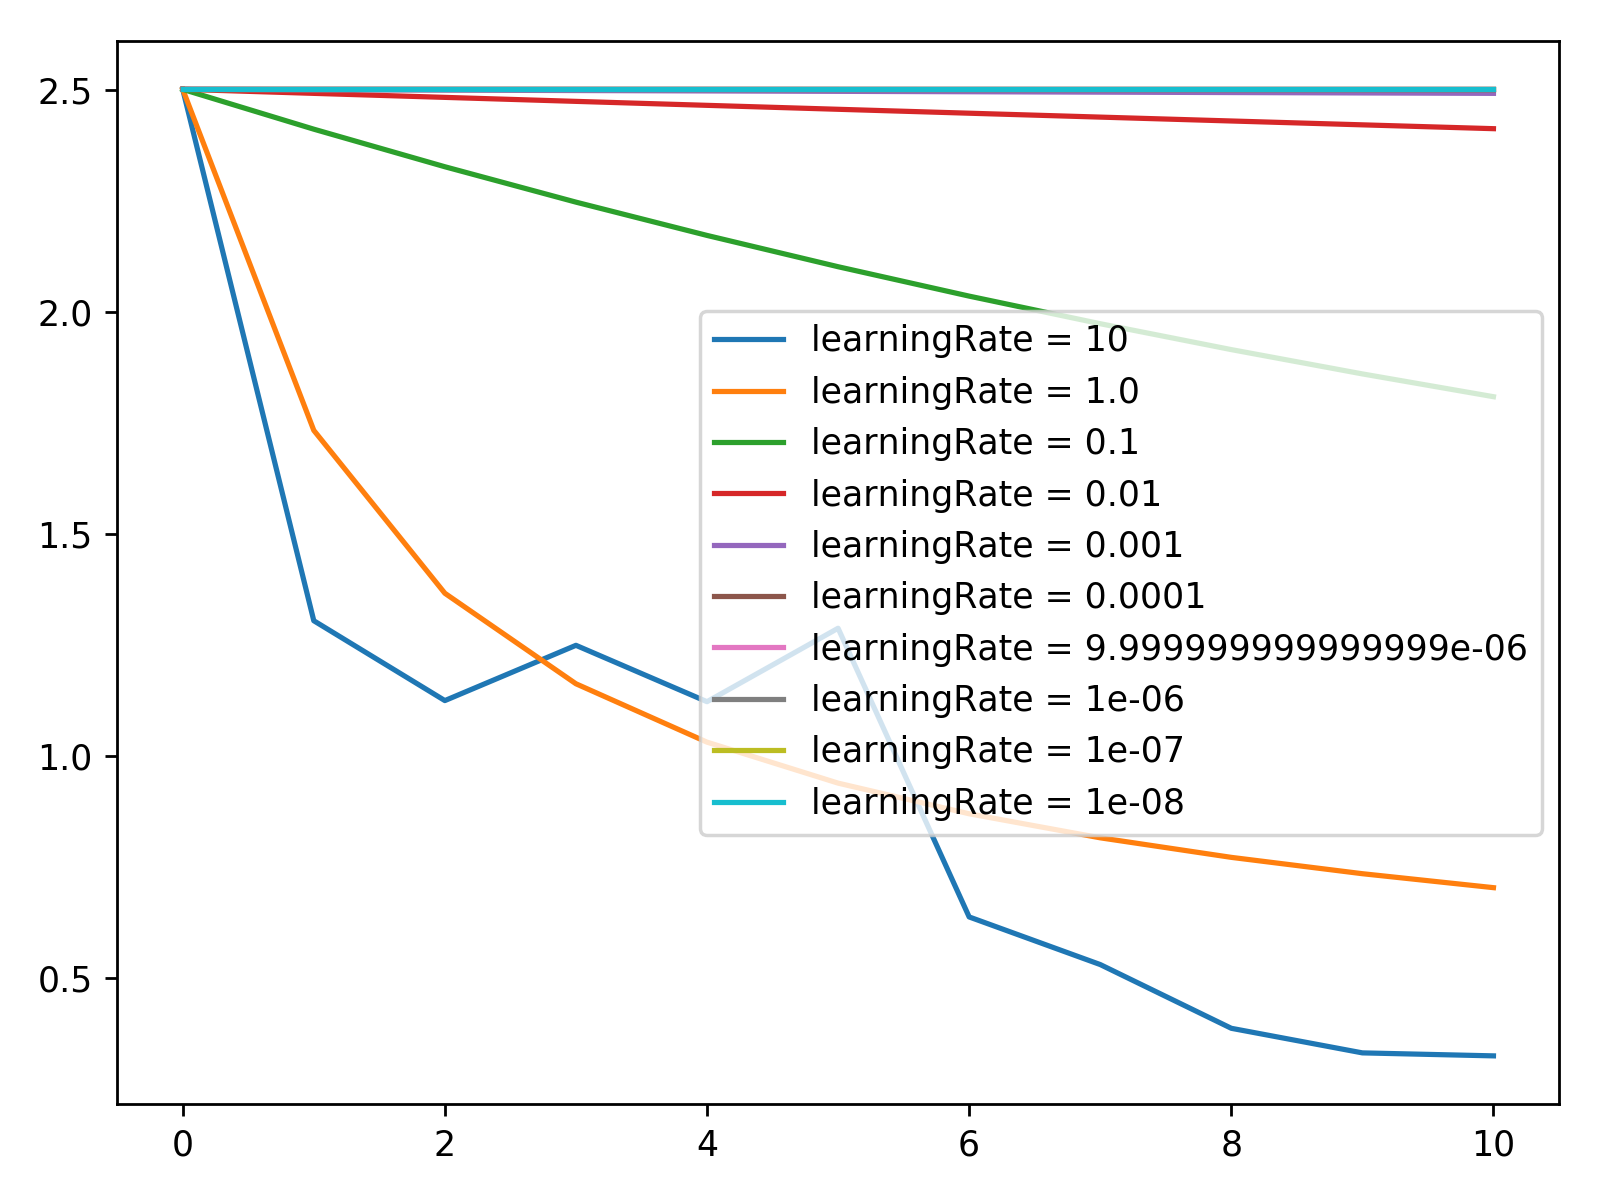

In [40]:
plt.figure()
for i in range(10):
    learningRate = 10*(10**(-i))
    weight_history_compared ,cost_history_compared = gradient_descent(g,learningRate,10,w)
    plt.plot(np.arange((len(cost_history_compared))),cost_history_compared,label="learningRate = "+str(learningRate))

plt.legend()
plt.show()

From the figure above, the learning rate of 1.0 has a better learning perfromance than all others.
Besides, the learning rates larger than 1.0 will lead an overflow of computing.
Therefore, the value of 1.0 has been chosen as the learning rate in below study.

In [14]:
# run gradient descent to minimize cost
g = multiclass_softmax_normalized; max_its = 200; alpha_choice = 1;

weight_history_normalized,cost_history_normalized = gradient_descent(g,alpha_choice,max_its,w)

In [20]:
# multiclass counting cost
def multiclass_counting_cost_normalized(w):                
    # pre-compute predictions on all points
    all_evals = model(x_normalized,w)

    # compute predictions of each input point
    y_predict = (np.argmax(all_evals,axis = 1))[:,np.newaxis]

    # compare predicted label to actual label
    count = np.sum(np.abs(np.sign(y - y_predict)))

    # return number of misclassifications
    return count

In [21]:
#misclass_history = [counting_cost(weight_history[n]) for n in range(1+max_its)]
misclass_history_normalized = [multiclass_counting_cost_normalized(weight_history_normalized[n])
                               for n in range(1+max_its)]

<IPython.core.display.Javascript object>


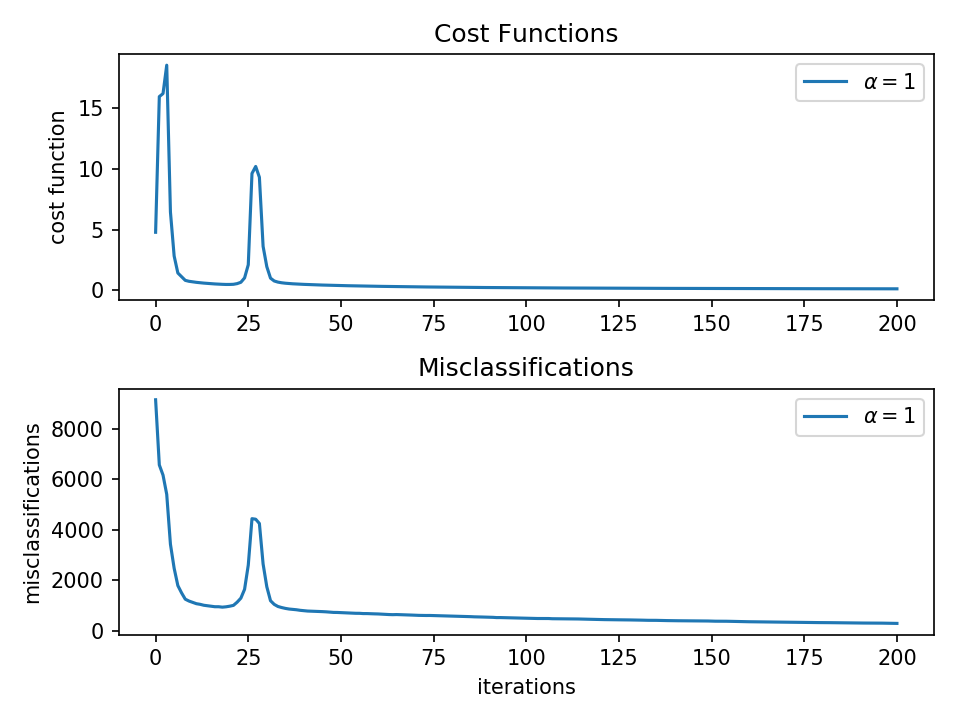

In [29]:
#plt.figure()
plt.figure()
plt.subplot(211)
plt.plot(np.arange((len(cost_history_normalized))), cost_history_normalized,label=r'$\alpha = 1$')
#plt.xlabel('iterations')
plt.ylabel('cost function')
plt.title('Cost Functions')

plt.legend()

plt.subplot(212)
#plt.plot(np.arange((len(misclass_history))), misclass_history, label='standard')
plt.plot(np.arange((len(misclass_history_normalized))), misclass_history_normalized,label=r'$\alpha = 1$')
plt.xlabel('iterations')
plt.ylabel('misclassifications')
plt.title('Misclassifications')
plt.legend()
plt.show()

In [36]:
print( misclass_history_normalized[max_its])

287.0


In [30]:
minIter = np.argmin(misclass_history_normalized)

In [31]:
minIter

200

As it is shown, the learning process with normalization in learning rate of 1 has got a 97% accuracy after 200 iterations.